These are moleculeNet benchmarks meant to sanity check our approaches

In [21]:
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pathlib import Path
import pandas as pd


plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=17)
plt.rc('figure', titlesize=20)

data_p = Path("/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/")






color_dict = {
    "smiles-pe.atomwise.0": "steelblue",
    "smiles-pe.bpe.0": "steelblue",   
    "smiles-pe.ngram.1": "steelblue",
    "smiles-pe.ngram.2": "steelblue",
    "smiles-pe.ngram.3": "steelblue",
    "ecfp.atomwise.0": "lightcoral",
    "rp.atomwise.0": "seagreen",
    "rf.atomwise.0": "plum",
#     "openhd": "green",
    "mlp.atomwise.0": "slateblue"
}

marker_dict = {
#     "smiles-pe": "+",
    "smiles-pe.atomwise.0": "+",
    "smiles-pe.bpe.0": "+",   
    "smiles-pe.ngram.1": "+",
    "smiles-pe.ngram.2": "+",
    "smiles-pe.ngram.3": "+",
    "ecfp.atomwise.0": "+",
    "rp.atomwise.0": "+",
    "rf.atomwise.0": "^",
#     "openhd": "*",
    "mlp.atomwise.0": "+"
}














def plot_confusion_matrix(y_pred, y_true, ax):

    cm = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=[0,1], normalize="true")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])
    disp.plot(cmap="Purples", ax=ax)
    
    
    
from sklearn.metrics import RocCurveDisplay, roc_curve, auc

def plot_roc_curve(y_score, y_true, ax, name):
    
    fpr, tpr, thresholds = roc_curve(y_score=y_score, y_true=y_true)
    roc_auc = auc(fpr, tpr)


    disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    disp.plot(ax=ax, name=name)
    
    
    
def plot_dist_plot(y_score, y_true, ax):
    
    neg_dist = y_score[y_true == 0]
    pos_dist = y_score[y_true == 1]
    
    
    sns.distplot(neg_dist, color="blue", ax=ax)
    sns.distplot(pos_dist, color="red", ax=ax)
    

In [22]:
def bbbp_main(split_type):
    

    
    roc_f, roc_ax = plt.subplots(1,1, figsize=(10,6))


    data_path_list = list(data_p.glob(f"bbbp.{split_type}*.pkl"))        

    for path in data_path_list:
#         import pdb 
#         pdb.set_trace()
        model = path.name.split(".")[2]
        if model == "smiles-pe":
            tokenizer = path.name.split('.')[3]            
            ngram_order = path.name.split('.')[4]
            
            if tokenizer == "ngram":
                model = f"{model}.{tokenizer}.{ngram_order}"
            else:
                model = f"{model}.{tokenizer}"
        
        with open(path, "rb") as handle:
            data = pickle.load(handle)

            
            
            y_pred = data[0]['y_pred']
            y_true = data[0]['y_true']
            y_score = data[0]['eta']

            score = None
                
            if y_score.squeeze().ndim < 2:
                score = y_score
            else:
                score = y_score[:, 1]

            plot_roc_curve(y_score=score, y_true=y_true, ax=roc_ax, name=model)

            
            
    roc_ax.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    roc_ax.set_xlabel("FPR")
    roc_ax.set_ylabel("TPR")
#     roc_f.suptitle("Blood-Brain-Barrier Permeability Reciever Operating Curve")
    plt.savefig(f"bbbp_{split_type}_roc.png", dpi=600, bbox_inches="tight")


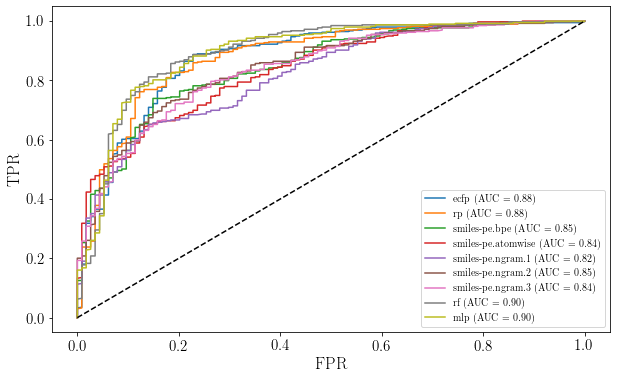

In [23]:
bbbp_main(split_type="random")

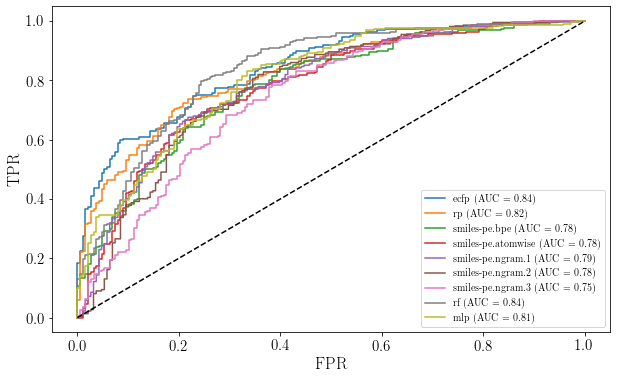

In [24]:
bbbp_main(split_type="scaffold")

In [44]:
def sider_main(split_type):
    
    
    f, ax = plt.subplots(1,1, figsize=(10,7))
    
    
    model_dict = {"model": [], "task": [], "roc-auc": []}
#     for model, color in [("smiles-pe", "blue"), ("ecfp", "red"), ("rp", "green"), ("rf", "orange"), ("mlp", "pink")]:
    for model in color_dict.keys():
#         import pdb
#         pdb.set_trace()
        data_path_list = list(data_p.glob(f"sider.*.{split_type}.{model}.pkl"))        
        print(model, len(data_path_list))


        for path in data_path_list:
            with open(path, "rb") as handle:
                
                
                data = pickle.load(handle)

                name = str(path.name).split('.')[-2]
                
#     '''
                task = int(str(path.name).split('.')[1].split('_')[-1])
            
                y_pred = data[0]['y_pred']
                y_true = data[0]['y_true']
                y_score = data[0]['eta']

                score = None
                
                if y_score.squeeze().ndim < 2:
                    score = y_score
                else:
                    score = y_score[:, 1]
                fpr, tpr, thresholds = roc_curve(y_score=score, y_true=y_true)
                roc_auc = auc(fpr, tpr)
                
                model_dict["model"].append(model)
                model_dict["task"].append(task)
                model_dict["roc-auc"].append(roc_auc)

    
    

    
    
    
    df = pd.DataFrame(model_dict)
    print(len(df.groupby("model")))
#     import pdb
#     pdb.set_trace()
    g = sns.boxplot(data=df, x="model", y="roc-auc", ax=ax, palette=color_dict)
#     , height=6, aspect=1.25) kind="box", palette="deep",
#     g.fig.gca().set_ylabel("ROC-AUC")
#     g.fig.gca().set_xlabel("Model")
    ax.tick_params(axis="x", labelrotation=45)

    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels[0] = "smiles.atomwise"
    labels[1] = "smiles.bpe"
    labels[2] = "smiles.uni-gram"
    labels[3] = "smiles.bi-gram"
    labels[4] = "smiles.tri-gram"
    labels[5] = "ecfp"
    labels[6] = "rp"
    labels[7] = "rf"
    labels[8] = "mlp"
    ax.set_xticklabels(labels)
    plt.tight_layout()
#     g.fig.suptitle("SIDER ROC-AUC Distribution Over Tasks")
    plt.savefig(f"sider_result_{split_type}_roc.png", dpi=600, bbox_inches="tight") 
#     '''

smiles-pe.atomwise.0 27
smiles-pe.bpe.0 27
smiles-pe.ngram.1 27
smiles-pe.ngram.2 27
smiles-pe.ngram.3 27
ecfp.atomwise.0 27
rp.atomwise.0 27
rf.atomwise.0 27
mlp.atomwise.0 27
9


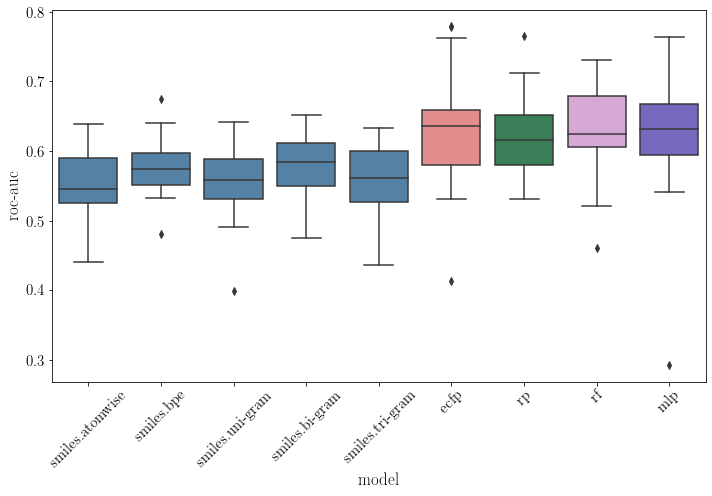

In [45]:
sider_main(split_type="random")

smiles-pe.atomwise.0 27
smiles-pe.bpe.0 27
smiles-pe.ngram.1 27
smiles-pe.ngram.2 27
smiles-pe.ngram.3 27
ecfp.atomwise.0 27
rp.atomwise.0 27
rf.atomwise.0 27
mlp.atomwise.0 27
9


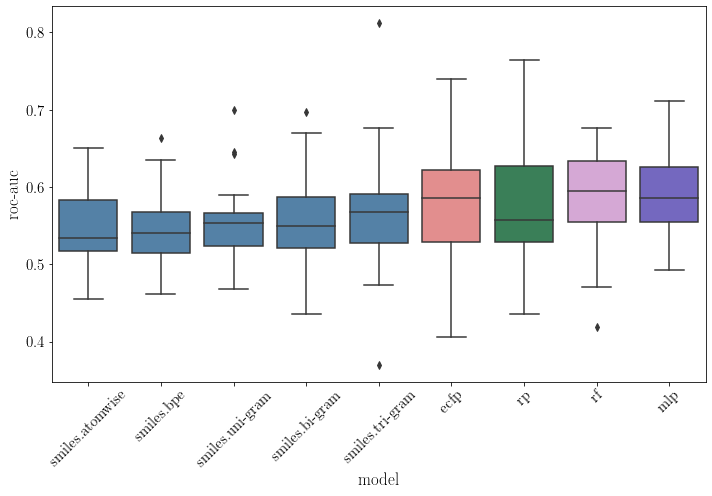

In [46]:
sider_main(split_type="scaffold")

In [100]:
def clintox_main(split_type):    
    
    f, ax = plt.subplots(1,1, figsize=(10,6))

    
    
    data_p = Path("/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/")
    model_dict = {"model": [], "task": [], "roc-auc": []}
#     for model, color in [("smiles-pe", "blue"), ("ecfp", "red"), ("rp", "green"), ("rf", "orange"), ("mlp", "pink")]:
    for model in color_dict.keys():

        
        data_path_list = list(data_p.glob(f"clintox*{split_type}.{model}.pkl"))        
        
        for path in data_path_list:
            with open(path, "rb") as handle:
                
                
                data = pickle.load(handle)

                name = str(path.name).split('.')[-2]
                

#                 task = int(str(path.name).split('.')[0].split('_')[-2])
                task = int(str(path.name).split('.')[1].split('_')[-1])

            
                y_pred = data[0]['y_pred']
                y_true = data[0]['y_true']
                y_score = data[0]['eta']

                score = None
                
                if y_score.squeeze().ndim < 2:
                    score = y_score
                else:
                    score = y_score[:, 1]
                fpr, tpr, thresholds = roc_curve(y_score=score, y_true=y_true)
                roc_auc = auc(fpr, tpr)
                
                model_dict["model"].append(model)
                model_dict["task"].append(task)
                model_dict["roc-auc"].append(roc_auc)

    
    df = pd.DataFrame(model_dict)
    print(df)
    ax = df.groupby(["model","task"]).mean().unstack().plot.barh(ax=ax, color=["salmon", "steelblue"])

#     import pdb
#     pdb.set_trace()
    ax.legend(['FDA Approved', 'CT TOX'])
    ax.set_ylabel("ROC-AUC")
    ax.set_xlabel("Model")
    
    
    labels = [item.get_text() for item in ax.get_yticklabels()]
    # sanity check safegaurd
    print(labels)

    labels[8] = "smiles.tri-gram"
    labels[7] = "smiles.bi-gram"
    labels[6] = "smiles.uni-gram"
    labels[5] = "smiles.bpe"
    labels[4] = "smiles.atomwise"
    labels[3] = "rp"
    labels[2] = "rf"
    labels[1] = "mlp"
    labels[0] = "ecfp"
    ax.set_yticklabels(labels)
    ax.tick_params(axis="y", labelrotation=30)
    
    
    plt.tight_layout()
#     plt.xticks(rotate=30, horizontalalignment="center")
#     g.fig.suptitle("SIDER ROC-AUC Distribution Over Tasks")
    plt.savefig(f"clintox_{split_type}_roc.png", dpi=600, bbox_inches="tight") 
#     import pdb 
#     pdb.set_trace()


    

                   model  task   roc-auc
0   smiles-pe.atomwise.0     0  0.950235
1   smiles-pe.atomwise.0     1  0.918571
2        smiles-pe.bpe.0     0  0.886761
3        smiles-pe.bpe.0     1  0.847714
4      smiles-pe.ngram.1     0  0.946854
5      smiles-pe.ngram.1     1  0.913571
6      smiles-pe.ngram.2     0  0.978967
7      smiles-pe.ngram.2     1  0.922286
8      smiles-pe.ngram.3     0  0.929765
9      smiles-pe.ngram.3     1  0.864714
10       ecfp.atomwise.0     0  0.791362
11       ecfp.atomwise.0     1  0.751857
12         rp.atomwise.0     0  0.847324
13         rp.atomwise.0     1  0.839286
14         rf.atomwise.0     0  0.792488
15         rf.atomwise.0     1  0.745000
16        mlp.atomwise.0     0  0.824789
17        mlp.atomwise.0     1  0.796857
['ecfp.atomwise.0', 'mlp.atomwise.0', 'rf.atomwise.0', 'rp.atomwise.0', 'smiles-pe.atomwise.0', 'smiles-pe.bpe.0', 'smiles-pe.ngram.1', 'smiles-pe.ngram.2', 'smiles-pe.ngram.3']


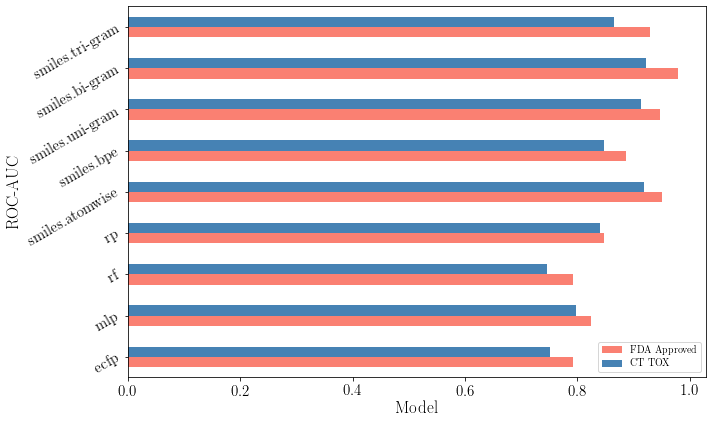

In [101]:
clintox_main(split_type="random")

                   model  task   roc-auc
0   smiles-pe.atomwise.0     0  0.937604
1   smiles-pe.atomwise.0     1  0.954248
2        smiles-pe.bpe.0     0  0.808066
3        smiles-pe.bpe.0     1  0.884461
4      smiles-pe.ngram.1     0  0.946856
5      smiles-pe.ngram.1     1  0.940755
6      smiles-pe.ngram.2     0  0.937841
7      smiles-pe.ngram.2     1  0.942441
8      smiles-pe.ngram.3     0  0.885884
9      smiles-pe.ngram.3     1  0.910394
10       ecfp.atomwise.0     0  0.750652
11       ecfp.atomwise.0     1  0.698819
12         rp.atomwise.0     0  0.809490
13         rp.atomwise.0     1  0.797175
14         rf.atomwise.0     0  0.711269
15         rf.atomwise.0     1  0.695973
16        mlp.atomwise.0     0  0.520996
17        mlp.atomwise.0     1  0.715370
['ecfp.atomwise.0', 'mlp.atomwise.0', 'rf.atomwise.0', 'rp.atomwise.0', 'smiles-pe.atomwise.0', 'smiles-pe.bpe.0', 'smiles-pe.ngram.1', 'smiles-pe.ngram.2', 'smiles-pe.ngram.3']


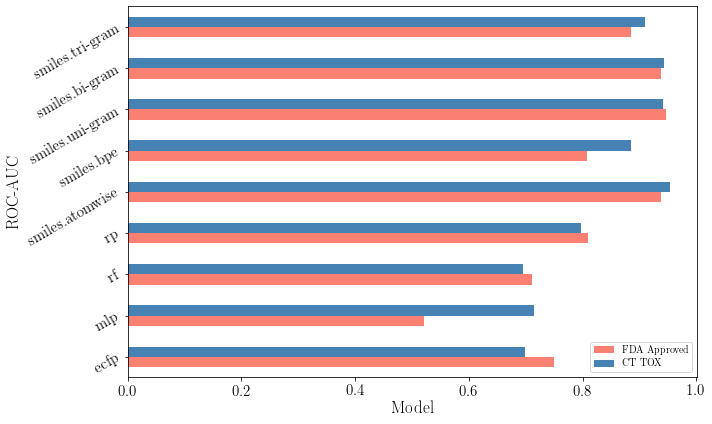

In [102]:
clintox_main(split_type="scaffold")